Author: Carlos Roberto
    
Date: 08/20/20

Obj: Primeiros testes com Emcee externo ao Pyautolens. Vamos gerar um modelo MGE e usando um M/L ratio.

In [3]:
import autolens as al
import autolens.plot as aplt
from pyprojroot import here
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


In [33]:
#Defing the grid
grid = al.Grid.uniform(shape_2d=(80, 80), pixel_scales=0.1, sub_size=1)
psf = al.Kernel.from_gaussian(shape_2d=(11, 11), sigma=0.1, pixel_scales=0.1)

In [34]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

#MGE parameters
#Reading data
Surf_mge, sigma, qObs = np.loadtxt('SphericalNFW MGE.txt', unpack=True)

#Converting and computing some quantities
Surf_mge = Surf_mge*(u.solMass/u.pc**2)                        #Surface Density in M_sun/pc²
sigma = sigma*u.arcsec                                         #Sigma in arcsec
sigma_pc = (sigma*D_l).to(u.pc, u.dimensionless_angles())      #Convert sigma in arcsec to sigma in pc
Mass_mge = 2*np.pi*Surf_mge*(sigma_pc**2)*qObs                 #Total mass per gaussian component in M_sun




#Defining inputs for the integral below
i = np.deg2rad(90)*u.rad                                       #Inclination angle in rad
M0 = Mass_mge                                                  #Mass per gaussian component in M_sun
q0 = np.sqrt(qObs**2 - np.cos(i)**2)/np.sin(i)                 #Deprojected axial ratio
sigma0 = (sigma).to(u.rad)                                     #Sigma per gaussian in rad
M0.sum()

<Quantity 1.76749207e+12 solMass>

In [108]:
#Defining the original lens mass model
ml = 7.35     #Mass to light to modify the mass profile
mass_profile = al.mp.MGE(centre=(0.0, 0.0))
mass_profile.MGE_comps(M=0.93*M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)
    
lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

In [119]:
#Defining the source model
source_galaxy = al.Galaxy(
    redshift=2.1,
    light=al.lp.EllipticalSersic(
        centre=(0, 0),
        elliptical_comps=(0.3, 0.111111),
        intensity=1.85,
        effective_radius=10.8,
        sersic_index=4,
    ),
)

In [120]:
#Ray tracing the source galaxy
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

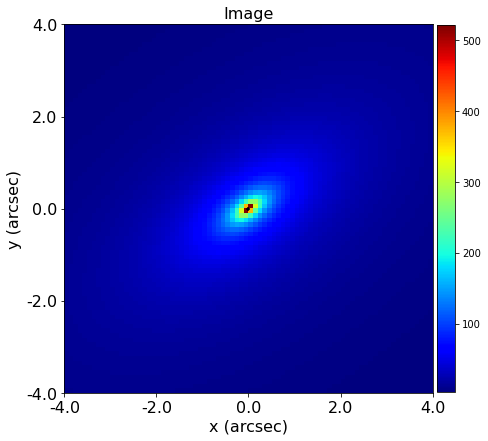

In [121]:
#Save image of source galaxy and plot it
plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Emcee Model/Image/',
                                          filename='Source Galaxy',
                                           format='png'),
                       labels=aplt.Labels(title='Source Galaxy'),             
                      )

aplt.Galaxy.image(galaxy=source_galaxy, grid=grid, 
                  plotter=plotter)
aplt.Galaxy.image(galaxy=source_galaxy, grid=grid)

Critical curve could not be calculated due to an unphysical mass model


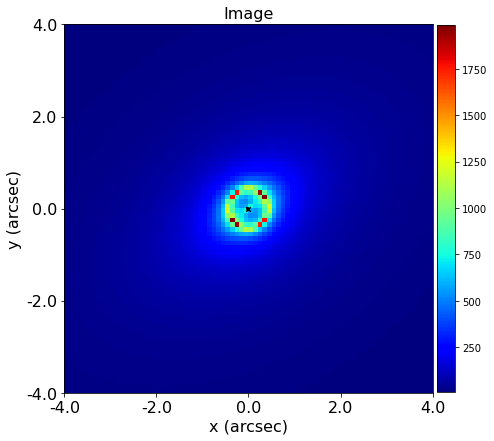

143.82741622299727


In [122]:
time = clock()
#Save image of arcs and plot it
plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Emcee Model/Image/',
                                          filename='Arcs',
                                           format='png'),
                       labels=aplt.Labels(title='Arcs'),             
                      )

aplt.Tracer.image(tracer=tracer, grid=grid)
print(clock() - time)

In [123]:
aplt.Tracer.image(tracer=tracer, grid=grid, plotter=plotter)

Critical curve could not be calculated due to an unphysical mass model


In [124]:
#Simulating the arcs image: Add Noise and PSF
simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.1, shape_2d=grid.shape_2d),
    add_noise=True,
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

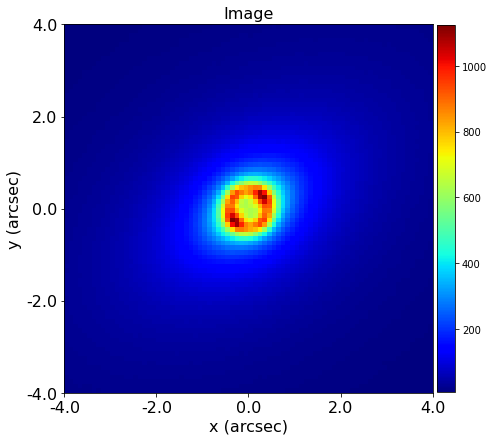

In [125]:
#Plot simulated image and save it
plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Emcee Model/Data/',
                                          filename='Simulated Arcs',
                                           format='png'),
                       labels=aplt.Labels(title='Arcs with Noise and PSF'),             
                      )
aplt.Imaging.image(imaging=imaging, plotter=plotter)
aplt.Imaging.image(imaging=imaging)

In [126]:
from pyprojroot import here

workspace_path = str(here())
dataset_path = f"{workspace_path}/howtolens/Emcee Model/Data/"
print("Dataset Path: ", dataset_path)

Dataset Path:  /home/carlos/autolens_workspace/howtolens/Emcee Model/Data/


In [127]:
#Save the simulated image in .fits file
imaging.output_to_fits(
    image_path=f"{dataset_path}ImageNFW.fits",
    noise_map_path=f"{dataset_path}NoiseNFW.fits",
    psf_path=f"{dataset_path}PSFNFW.fits",
    overwrite=True,
)